# Import libraries

In [38]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas_datareader.data as web

## ***Import database***

In [10]:
data = pd.read_excel("/home/poulami/Documents/temp/OnlineRetail.xlsx")

In [11]:
print(data.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


### [Breaktime](http://kissanime.ru/Anime/Steins-Gate/Episode-009?id=1507&s=default)

### ![picture](https://www.google.co.in/logos/doodles/2018/indias-republic-day-2018-5861462944776192-l.png)

In [12]:
data['total']=data.Quantity*data.UnitPrice
data['date']=data['InvoiceDate'].dt.date
print(data.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  total  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  15.30   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  20.34   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  22.00   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  20.34   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  20.34   

         date  
0  2010-12-01  
1  2010-12-01  
2  2010-12-01  
3  2010-12-01  
4  2010-12-01  


In [13]:
stockcode = data[["StockCode"]]

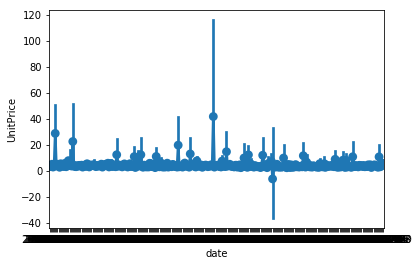

KeyboardInterrupt: 

In [16]:
#Don't run
for x in stockcode['StockCode']:
    i1 = data[data['StockCode'] ==  data['StockCode'][0]][['date','Quantity','total','UnitPrice']]
    ax = sns.pointplot(x='date', y='UnitPrice', data=data)
    plt.show()

In [48]:
df = data[data['StockCode'] ==  data['StockCode'][0]][['date','Quantity']]
dataframe=df.set_index('date')

In [49]:
np.random.seed(7)

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [50]:
# load the dataset
#dataframe = pd.read_csv('/home/poulami/Documents/Github/lstm-predictions/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)

#data = read_csv("")
#dataframe = web.DataReader('^GSPC','yahoo')['Open'].to_frame()
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [51]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)


Epoch 1/5
 - 4s - loss: 0.0038
Epoch 2/5
 - 3s - loss: 6.1340e-04
Epoch 3/5
 - 4s - loss: 6.0377e-04
Epoch 4/5
 - 3s - loss: 6.1488e-04
Epoch 5/5
 - 3s - loss: 6.0291e-04


In [52]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 141.91 RMSE
Test Score: 48.59 RMSE


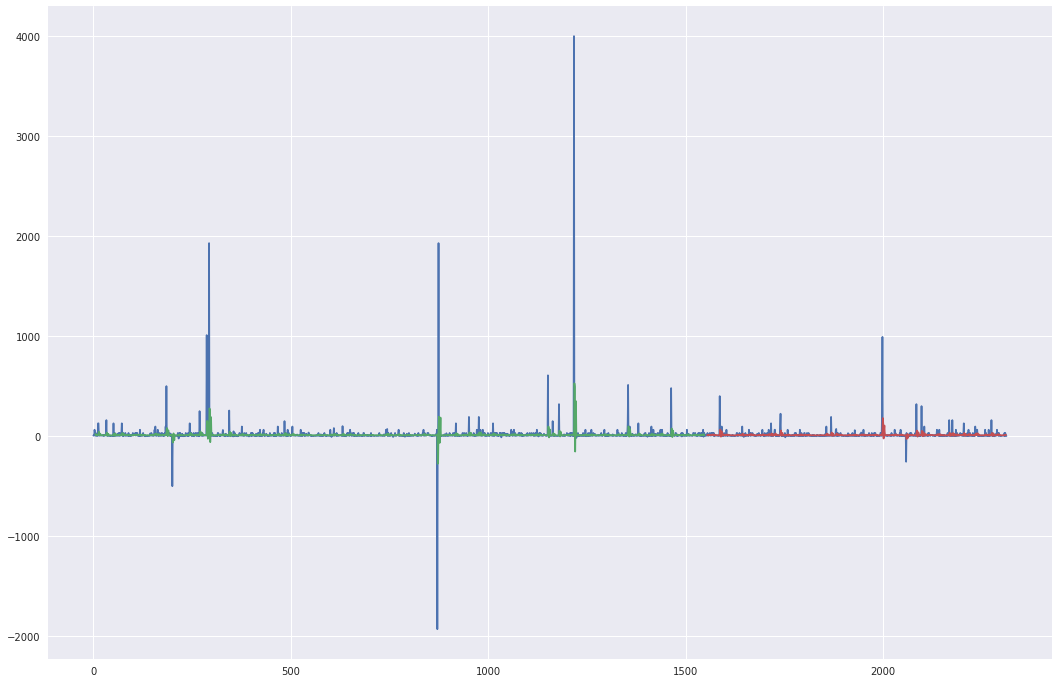

In [53]:
# Plotsize
plt.rcParams['figure.figsize'] = [18,12]

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()